In [88]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import sklearn.linear_model

from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

In [50]:
pd.set_option('display.max_columns', None)

df = pd.read_csv('https://raw.githubusercontent.com/fantasydatapros/LearnPythonWithFantasyFootball/master/2022/10-Machine%20Learning%20-%20Regression/1-Gridiron%20AI%20Curated%20Dataset%20-%202022.csv')

df.head()

,player_id,tm,pos,season,week,NFL_draft_year,NFL_draft_round,NFL_draft_rank,weight_pounds,forty_yd,three_cone,bench,broad_jump,combine_height,shuttle,vertical,player,height_inches,offensive_snapcount,offensive_snapcount_percentage,passing_int,passing_rating,passing_yds,passing_two_pt_md,passing_td,passing_att,passing_cmp,receiving_yds,receiving_td,receiving_rec,receiving_tar,rushing_att,rushing_td,rushing_yds,fumbles_lost,half_ppr_fantasy_points,ppr_fantasy_points,standard_fantasy_points
0,1626,CLT,TE,2008,2,2008.0,6.0,196.0,250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tom Santi,77.0,0,0,0,0.0,0,0,0,0,0,29,0,5,8,0,0,0,0,5.4,7.9,2.9
1,1626,CLT,TE,2008,3,2008.0,6.0,196.0,250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tom Santi,77.0,0,0,0,0.0,0,0,0,0,0,8,0,1,1,0,0,0,0,1.3,1.8,0.8
2,1626,CLT,TE,2008,5,2008.0,6.0,196.0,250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tom Santi,77.0,0,0,0,0.0,0,0,0,0,0,27,1,4,4,0,0,0,0,10.7,12.7,8.7
3,1626,CLT,TE,2008,6,2008.0,6.0,196.0,250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tom Santi,77.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
4,1626,CLT,TE,2008,7,2008.0,6.0,196.0,250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tom Santi,77.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0


In [51]:
df = df.groupby(['player_id', 'tm', 'player', 'pos', 'season'], as_index=False)\
    .agg({
    'offensive_snapcount': np.sum,
    'offensive_snapcount_percentage': np.mean,
    'passing_rating': np.mean,
    'passing_yds': np.sum,
    'passing_td': np.sum,
    'passing_att': np.sum,
    'receiving_yds': np.sum,
    'receiving_td': np.sum,
    'receiving_rec': np.sum,
    'receiving_tar': np.sum,
    'rushing_att': np.sum,
    'standard_fantasy_points': np.sum,
    'ppr_fantasy_points': np.sum,
    'half_ppr_fantasy_points': np.sum
})

df.head()

,player_id,tm,player,pos,season,offensive_snapcount,offensive_snapcount_percentage,passing_rating,passing_yds,passing_td,passing_att,receiving_yds,receiving_td,receiving_rec,receiving_tar,rushing_att,standard_fantasy_points,ppr_fantasy_points,half_ppr_fantasy_points
0,2,CHI,Justin Gage,WR,2003,0,0.0,0.0,0,0,0,338,2,17,35,0,45.8,62.8,54.3
1,2,CHI,Justin Gage,WR,2004,0,0.0,0.0,0,0,0,156,0,12,28,0,15.6,27.6,21.6
2,2,CHI,Justin Gage,WR,2005,0,0.0,0.0,0,0,0,374,2,34,65,0,49.4,83.4,66.4
3,2,CHI,Justin Gage,WR,2006,0,0.0,0.0,0,0,0,68,0,4,8,0,6.8,10.8,8.8
4,2,OTI,Justin Gage,WR,2007,0,0.0,0.0,0,0,0,769,2,56,90,0,88.9,144.9,116.9


In [52]:
df = df.loc[(df['season'] >= 2012)]

In [53]:
pd.set_option('chained_assignment', None)

lag_features = ['rushing_att', 
               'receiving_tar', 
               'offensive_snapcount', 
               'offensive_snapcount_percentage',
                'ppr_fantasy_points',
                'passing_rating',
                'passing_att', 
                'passing_td']

for lag in range(1, 6):
    shifted = df.groupby('player_id').shift(lag)
    for column in lag_features:
        df[f'lag_{column}_{lag}'] = shifted[column]

df = df.fillna(-1)

In [55]:
wr_df = df.loc[(df['pos'] == 'WR') & (df['season'] < 2021)]
wr_df = wr_df.loc[wr_df['lag_offensive_snapcount_1'] > 50]

In [56]:
wr_df['lag_offensive_snapcount_norm'] = (wr_df['lag_offensive_snapcount_1'] - wr_df['lag_offensive_snapcount_1'].min()) / (wr_df['lag_offensive_snapcount_1'].max() - wr_df['lag_offensive_snapcount_1'].min())
wr_df['lag_receiving_tar_norm'] = (wr_df['lag_receiving_tar_1'] - wr_df['lag_receiving_tar_1'].min()) / (wr_df['lag_receiving_tar_1'].max() - wr_df['lag_receiving_tar_1'].min())   

In [57]:
wr_df.describe()

,player_id,season,offensive_snapcount,offensive_snapcount_percentage,passing_rating,passing_yds,passing_td,passing_att,receiving_yds,receiving_td,receiving_rec,receiving_tar,rushing_att,standard_fantasy_points,ppr_fantasy_points,half_ppr_fantasy_points,lag_rushing_att_1,lag_receiving_tar_1,lag_offensive_snapcount_1,lag_offensive_snapcount_percentage_1,lag_ppr_fantasy_points_1,lag_passing_rating_1,lag_passing_att_1,lag_passing_td_1,lag_rushing_att_2,lag_receiving_tar_2,lag_offensive_snapcount_2,lag_offensive_snapcount_percentage_2,lag_ppr_fantasy_points_2,lag_passing_rating_2,lag_passing_att_2,lag_passing_td_2,lag_rushing_att_3,lag_receiving_tar_3,lag_offensive_snapcount_3,lag_offensive_snapcount_percentage_3,lag_ppr_fantasy_points_3,lag_passing_rating_3,lag_passing_att_3,lag_passing_td_3,lag_rushing_att_4,lag_receiving_tar_4,lag_offensive_snapcount_4,lag_offensive_snapcount_percentage_4,lag_ppr_fantasy_points_4,lag_passing_rating_4,lag_passing_att_4,lag_passing_td_4,lag_rushing_att_5,lag_receiving_tar_5,lag_offensive_snapcount_5,lag_offensive_snapcount_percentage_5,lag_ppr_fantasy_points_5,lag_passing_rating_5,lag_passing_att_5,lag_passing_td_5,lag_offensive_snapcount_norm,lag_receiving_tar_norm
count,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000
mean,4233.423298,2016.331419,481.822806,53.274823,0.591210,1.255127,0.025431,0.095980,474.034454,2.878589,36.392945,59.603774,2.092699,66.174897,102.567842,84.371370,2.270714,63.698113,513.216571,55.560742,109.085398,0.564010,0.111567,0.021329,1.305168,46.162428,361.594750,38.209064,80.359639,0.158606,-0.192781,-0.263331,0.476620,32.013946,247.943396,25.827541,55.685234,-0.167580,-0.464315,-0.502051,-0.036095,21.717801,168.526661,17.447268,38.378425,-0.394371,-0.637408,-0.664479,-0.292043,14.223134,110.434783,10.905739,25.486095,-0.575122,-0.765381,-0.785070,0.372155,0.299052
std,5610.752870,2.429652,338.382320,28.586186,2.656591,7.299575,0.167596,0.355314,430.106662,3.250367,31.843841,49.644083,7.272467,61.028409,91.877395,76.350859,7.155938,48.184246,317.910955,26.345338,88.935354,2.630903,0.915487,0.150111,6.419546,53.162513,371.385209,34.772847,96.047882,2.571984,1.036167,0.481574,4.289032,50.143348,354.282768,34.301666,89.550178,2.375201,0.614011,0.528921,3.058597,44.589267,315.594515,31.237586,79.801053,2.056715,0.581413,0.502679,3.961849,38.966632,270.411502,26.775804,69.458282,1.839462,0.511685,0.439891,0.255967,0.226217
min,8.000000,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,-2.400000,-2.000000,-2.000000,0.000000,0.000000,51.000000,4.750000,-1.500000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000
25%,2229.000000,2014.000000,169.500000,26.851648,0.000000,0.000000,0.000000,0.000000,94.000000,0.000000,9.000000,16.000000,0.000000,12.750000,20.900000,17.000000,0.000000,22.000000,221.500000,32.895833,35.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,

MAE: 54.93008319388268
RMSE: 69.036574534556
Equation: y = 24.87 + 296.05x1 + -27.31x2


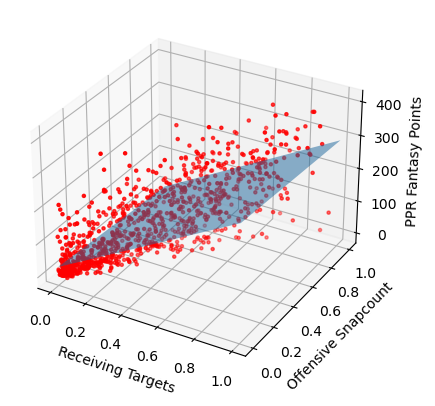

In [84]:


X = wr_df[['lag_receiving_tar_norm', 'lag_offensive_snapcount_norm']].values#, 'lag_ppr_fantasy_points_1']].values
y = wr_df['ppr_fantasy_points'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], y_train, marker='.', color='red')
ax.set_xlabel("Receiving Targets")
ax.set_ylabel("Offensive Snapcount")
ax.set_zlabel("PPR Fantasy Points")

model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MAE: {}".format(np.abs(y_test-y_pred).mean()))
print("RMSE: {}".format(np.sqrt(((y_test-y_pred)**2).mean())))

coefs = model.coef_
intercept = model.intercept_
xs = np.tile(np.arange(2), (2,1))
ys = np.tile(np.arange(2), (2,1)).T
zs = xs*coefs[0]+ys*coefs[1]+intercept
print("Equation: y = {:.2f} + {:.2f}x1 + {:.2f}x2".format(intercept, coefs[0],
                                                          coefs[1]))

ax.plot_surface(xs,ys,zs, alpha=0.5)
plt.show()

MAE: 54.93008319388268
RMSE: 69.036574534556
Equation: y = 24.87 + 296.05x1 + -27.31x2
MAE: 54.93008319388268
RMSE: 69.036574534556
Equation: y = 24.87 + 296.05x1 + -27.31x2


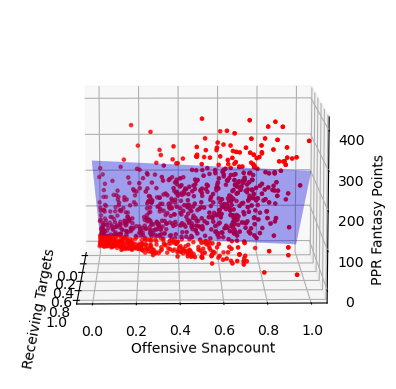

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
def init():

    X = wr_df[['lag_receiving_tar_norm', 'lag_offensive_snapcount_norm']].values#, 'lag_ppr_fantasy_points_1']].values
    y = wr_df['ppr_fantasy_points'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


    ax.scatter(X_train[:,0], X_train[:,1], y_train, marker='.', color='red')
    ax.set_xlabel("Receiving Targets")
    ax.set_ylabel("Offensive Snapcount")
    ax.set_zlabel("PPR Fantasy Points")

    model = sklearn.linear_model.LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("MAE: {}".format(np.abs(y_test-y_pred).mean()))
    print("RMSE: {}".format(np.sqrt(((y_test-y_pred)**2).mean())))

    coefs = model.coef_
    intercept = model.intercept_
    xs = np.tile(np.arange(2), (2,1))
    ys = np.tile(np.arange(2), (2,1)).T
    zs = xs*coefs[0]+ys*coefs[1]+intercept
    print("Equation: y = {:.2f} + {:.2f}x1 + {:.2f}x2".format(intercept, coefs[0],
                                                              coefs[1]))

    ax.plot_surface(xs,ys,zs, alpha=0.2,color='blue')
    return fig,
def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,
# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# Save
anim.save('mlr_nfl.mp4', fps=30, extra_args=['-vcodec', 'libx264'])